# EOSC 454 / 556B — Assignment 3: Linear Inverse Problem
**Due:** February 23, 2026  
**Name:** Shawn Gabriel Intong


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

os.makedirs('figures', exist_ok=True)

# Global plot style
plt.rcParams.update({
    'font.size': 11,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'legend.fontsize': 9,
    'figure.dpi': 120,
})

# ── Shared mesh ──────────────────────────────────────────────────────────────
n_cells = 100
x = np.linspace(0, 1, n_cells)   # cell centres
dx = x[1] - x[0]

print(f'Mesh: {n_cells} cells, dx = {dx:.4f}')

Mesh: 100 cells, dx = 0.0101


---
# Q1 — Forward Simulation with Decaying Exponential Kernels

## Q1a — Kernel function and the roles of p, q, j

The kernel is defined as:
$$g_j(x) = e^{jpx}\cos(2\pi j q x)$$

- **$p$**: decay rate of the exponential envelope (negative $p$ → decay left-to-right; larger $|p|$ → faster decay)
- **$q$**: oscillation frequency of the cosine (larger $q$ → more rapid oscillations)
- **$j$**: kernel index; larger $j$ amplifies both decay and oscillation simultaneously

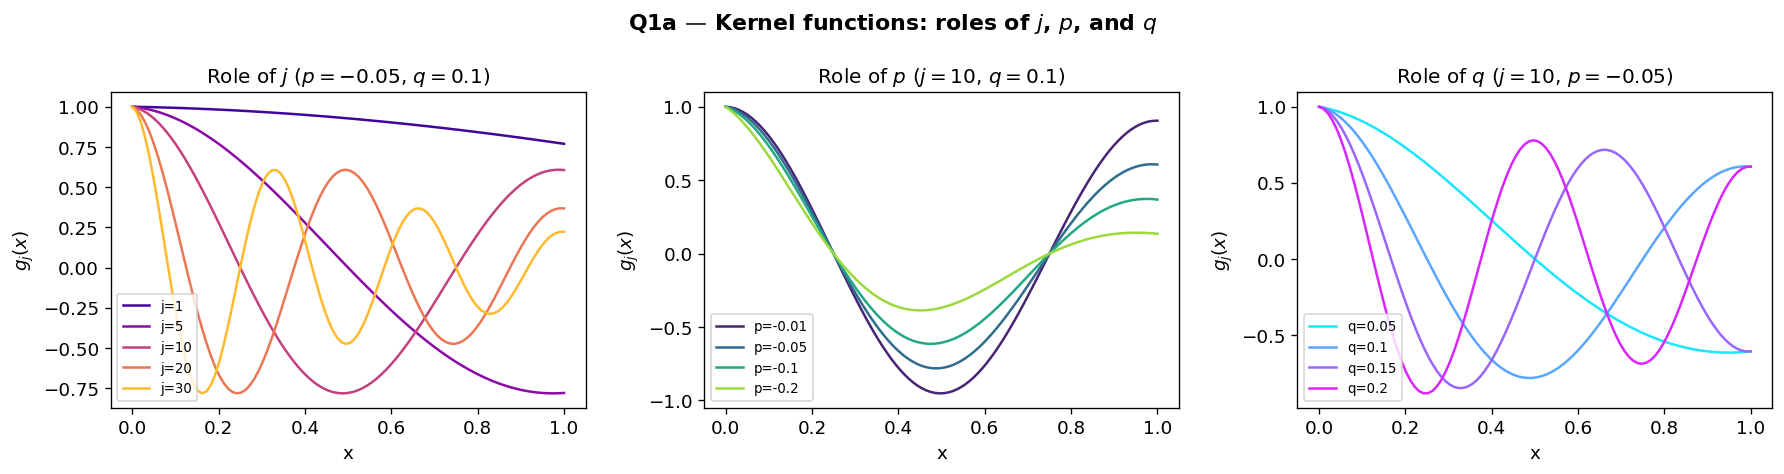

In [2]:
def kernel(j, p, q, x):
    """
    Compute the j-th kernel function on mesh x.

    Parameters
    ----------
    j : float  -- kernel index
    p : float  -- decay rate parameter
    q : float  -- oscillation frequency parameter
    x : array  -- spatial locations

    Returns
    -------
    g : array  -- kernel values at each x
    """
    return np.exp(j * p * x) * np.cos(2 * np.pi * j * q * x)


# ── Figure: role of j, then p, then q ────────────────────────────────────────
j_demo = [1, 5, 10, 20, 30]
colors = cm.plasma(np.linspace(0.1, 0.85, len(j_demo)))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Panel 1: role of j  (fixed p, q)
for j, c in zip(j_demo, colors):
    axes[0].plot(x, kernel(j, -0.05, 0.1, x), color=c, label=f'j={j}')
axes[0].set_title('Role of $j$ ($p=-0.05$, $q=0.1$)')
axes[0].set_xlabel('x'); axes[0].set_ylabel('$g_j(x)$')
axes[0].legend(fontsize=8)

# Panel 2: role of p  (fixed j=10, q=0.1)
p_vals = [-0.01, -0.05, -0.10, -0.20]
colors_p = cm.viridis(np.linspace(0.1, 0.85, len(p_vals)))
for p_v, c in zip(p_vals, colors_p):
    axes[1].plot(x, kernel(10, p_v, 0.1, x), color=c, label=f'p={p_v}')
axes[1].set_title('Role of $p$ ($j=10$, $q=0.1$)')
axes[1].set_xlabel('x'); axes[1].set_ylabel('$g_j(x)$')
axes[1].legend(fontsize=8)

# Panel 3: role of q  (fixed j=10, p=-0.05)
q_vals = [0.05, 0.10, 0.15, 0.20]
colors_q = cm.cool(np.linspace(0.1, 0.85, len(q_vals)))
for q_v, c in zip(q_vals, colors_q):
    axes[2].plot(x, kernel(10, -0.05, q_v, x), color=c, label=f'q={q_v}')
axes[2].set_title('Role of $q$ ($j=10$, $p=-0.05$)')
axes[2].set_xlabel('x'); axes[2].set_ylabel('$g_j(x)$')
axes[2].legend(fontsize=8)

fig.suptitle('Q1a — Kernel functions: roles of $j$, $p$, and $q$', fontweight='bold')
plt.tight_layout()
plt.savefig('figures/q1a_kernels.pdf', bbox_inches='tight')
plt.show()

## Q1b — Model: Gaussian + boxcar

$$m(x) = A_G\,\exp\!\left(-\frac{(x-\mu_G)^2}{2\sigma_G^2}\right) + A_B\,\mathbf{1}_{[x_1,x_2]}(x)$$

Parameters differ from the in-class example: the boxcar has a **negative amplitude** and is placed in the right half of the domain.

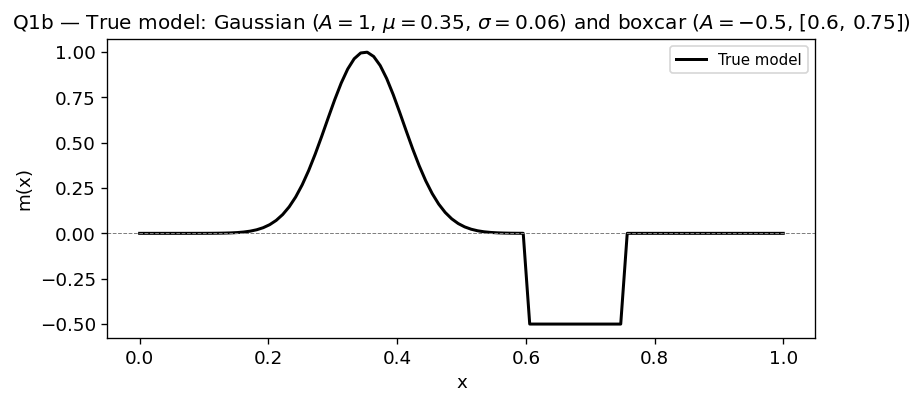

In [3]:
def make_model(x, A_G=1.0, mu_G=0.35, sig_G=0.06,
               A_B=-0.5, x1=0.60, x2=0.75):
    """Gaussian + boxcar true model."""
    gauss  = A_G * np.exp(-0.5 * ((x - mu_G) / sig_G) ** 2)
    boxcar = A_B * ((x >= x1) & (x <= x2)).astype(float)
    return gauss + boxcar


m_true = make_model(x)

fig, ax = plt.subplots(figsize=(7, 3.5))
ax.plot(x, m_true, 'k', linewidth=1.8, label='True model')
ax.axhline(0, color='gray', linewidth=0.6, linestyle='--')
ax.set_xlabel('x'); ax.set_ylabel('m(x)')
ax.set_title('Q1b — True model: Gaussian ($A=1$, $\\mu=0.35$, $\\sigma=0.06$) '
             'and boxcar ($A=-0.5$, $[0.6,\\,0.75]$)')
ax.legend()
plt.tight_layout()
plt.savefig('figures/q1b_model.pdf', bbox_inches='tight')
plt.show()

## Q1c — Forward simulation matrix G and data

$$G_{ji} = g_j(x_i)\,\Delta x$$

Using $N=20$ kernels, $j \in [0, 30]$ (evenly spaced), $p=-0.05$, $q=0.1$.

G shape: (20, 100)  (N_data × N_cells)


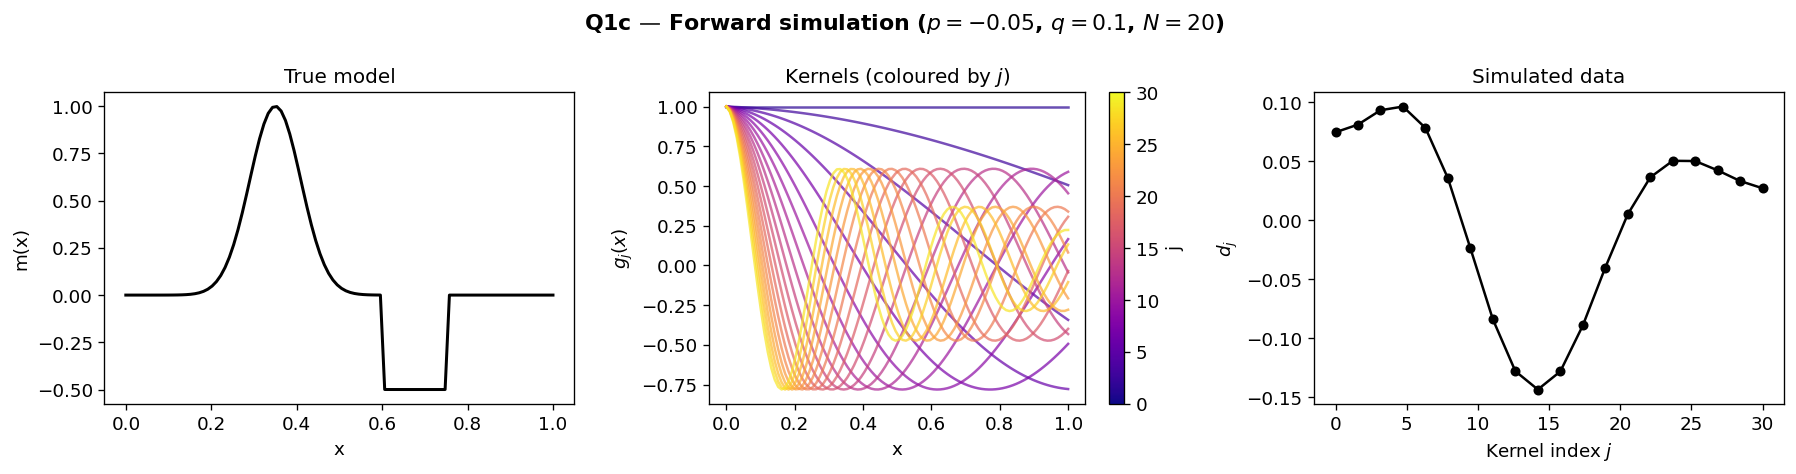

In [4]:
def build_G(j_vals, p, q, x):
    """Build the N×M forward simulation matrix G."""
    dx = x[1] - x[0]
    G  = np.zeros((len(j_vals), len(x)))
    for idx, j in enumerate(j_vals):
        G[idx, :] = kernel(j, p, q, x) * dx
    return G


# ── Main forward problem setup ────────────────────────────────────────────────
n_data  = 20
p_main  = -0.05
q_main  =  0.10
j_vals  = np.linspace(0, 30, n_data)

G      = build_G(j_vals, p_main, q_main, x)
d_true = G @ m_true

print(f'G shape: {G.shape}  (N_data × N_cells)')

# ── Three-panel figure ────────────────────────────────────────────────────────
colors_k = cm.plasma(np.linspace(0.05, 0.95, n_data))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(x, m_true, 'k', linewidth=1.8)
axes[0].set_xlabel('x'); axes[0].set_ylabel('m(x)')
axes[0].set_title('True model')

for i, g_row in enumerate(G):
    axes[1].plot(x, g_row / dx, color=colors_k[i], alpha=0.7)   # plot un-scaled kernel
axes[1].set_xlabel('x'); axes[1].set_ylabel('$g_j(x)$')
axes[1].set_title('Kernels (coloured by $j$)')
sm = plt.cm.ScalarMappable(cmap='plasma',
                            norm=plt.Normalize(vmin=j_vals[0], vmax=j_vals[-1]))
fig.colorbar(sm, ax=axes[1], label='j')

axes[2].plot(j_vals, d_true, 'ko-', markersize=5)
axes[2].set_xlabel('Kernel index $j$'); axes[2].set_ylabel('$d_j$')
axes[2].set_title('Simulated data')

fig.suptitle('Q1c — Forward simulation ($p=-0.05$, $q=0.1$, $N=20$)', fontweight='bold')
plt.tight_layout()
plt.savefig('figures/q1c_forward.pdf', bbox_inches='tight')
plt.show()

## Q1d — Sensitivity to boxcar and Gaussian amplitude changes

$$S = \frac{\|\mathbf{d}(m_1) - \mathbf{d}(m_2)\|}{\|\Delta m\|}$$

Sensitivity — Boxcar  (ΔA=0.5): S = 0.0801
Sensitivity — Gaussian (ΔA=0.5): S = 0.1049


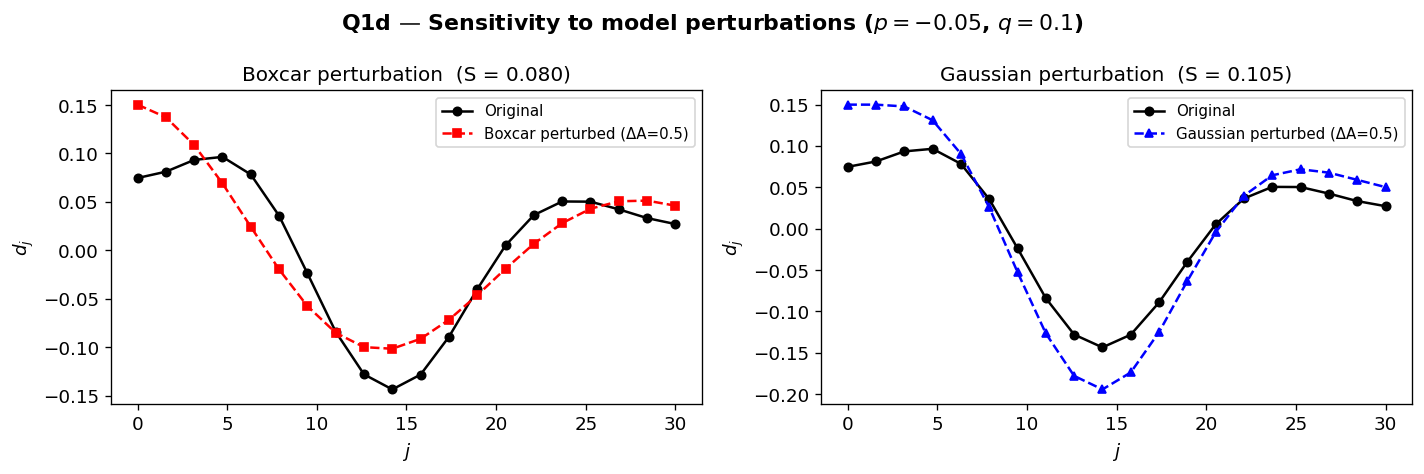

In [5]:
def sensitivity(G, m1, m2):
    """Compute sensitivity as ||d1 - d2|| / ||m1 - m2||."""
    d1 = G @ m1
    d2 = G @ m2
    delta_d = np.linalg.norm(d1 - d2)
    delta_m = np.linalg.norm(m1 - m2)
    return delta_d / delta_m, d1, d2


delta_A = 0.5   # perturbation size

# ── Boxcar perturbation ───────────────────────────────────────────────────────
m_boxcar_perturbed = make_model(x, A_B=-0.5 + delta_A)   # A_B changes from -0.5 → 0.0
S_box, d_orig, d_box = sensitivity(G, m_true, m_boxcar_perturbed)

# ── Gaussian perturbation ─────────────────────────────────────────────────────
m_gauss_perturbed = make_model(x, A_G=1.0 + delta_A)     # A_G changes from 1.0 → 1.5
S_gau, _, d_gau  = sensitivity(G, m_true, m_gauss_perturbed)

print(f'Sensitivity — Boxcar  (ΔA={delta_A}): S = {S_box:.4f}')
print(f'Sensitivity — Gaussian (ΔA={delta_A}): S = {S_gau:.4f}')

# ── Figure ────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(j_vals, d_orig, 'k-o', markersize=5, label='Original')
axes[0].plot(j_vals, d_box,  'r--s', markersize=5, label=f'Boxcar perturbed (ΔA={delta_A})')
axes[0].set_xlabel('$j$'); axes[0].set_ylabel('$d_j$')
axes[0].set_title(f'Boxcar perturbation  (S = {S_box:.3f})')
axes[0].legend()

axes[1].plot(j_vals, d_orig, 'k-o', markersize=5, label='Original')
axes[1].plot(j_vals, d_gau,  'b--^', markersize=5, label=f'Gaussian perturbed (ΔA={delta_A})')
axes[1].set_xlabel('$j$'); axes[1].set_ylabel('$d_j$')
axes[1].set_title(f'Gaussian perturbation  (S = {S_gau:.3f})')
axes[1].legend()

fig.suptitle('Q1d — Sensitivity to model perturbations ($p=-0.05$, $q=0.1$)', fontweight='bold')
plt.tight_layout()
plt.savefig('figures/q1d_sensitivity.pdf', bbox_inches='tight')
plt.show()

## Q1e — Effect of oscillation frequency q on sensitivity

     q |   S_boxcar |   S_gaussian
----------------------------------
  0.05 |     0.0841 |       0.1163
  0.10 |     0.0801 |       0.1049
  0.20 |     0.0712 |       0.0859


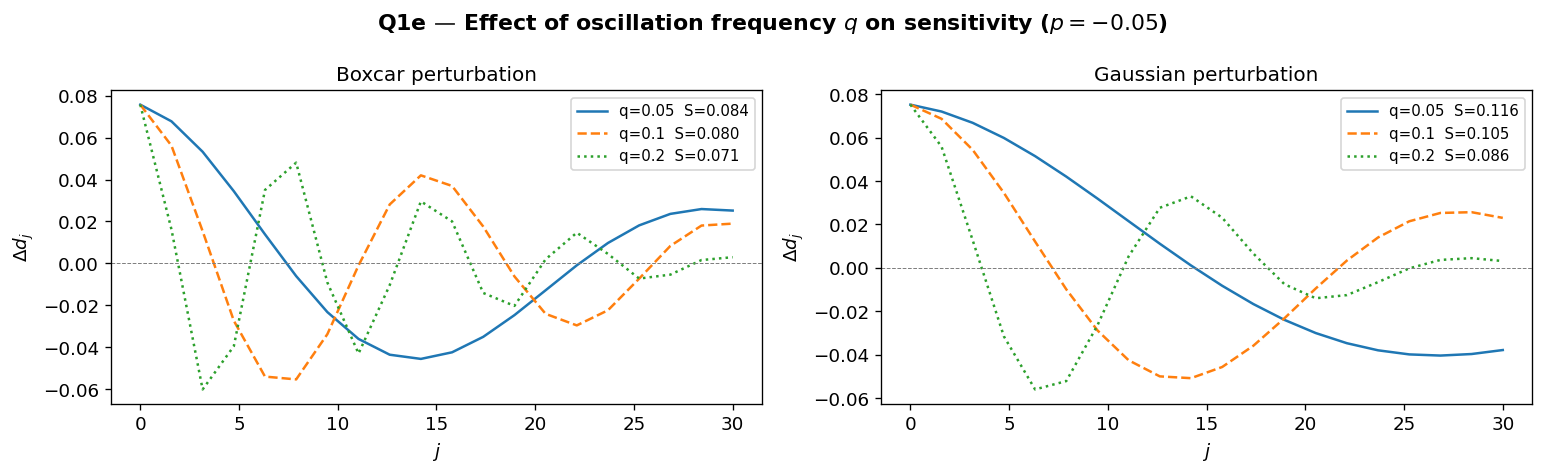

In [6]:
q_vals_exp = [0.05, 0.10, 0.20]
line_styles = ['-', '--', ':']

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

print(f'{'q':>6} | {'S_boxcar':>10} | {'S_gaussian':>12}')
print('-' * 34)

for q_v, ls in zip(q_vals_exp, line_styles):
    G_v    = build_G(j_vals, p_main, q_v, x)
    d_v    = G_v @ m_true
    d_box_v = G_v @ m_boxcar_perturbed
    d_gau_v = G_v @ m_gauss_perturbed

    S_b = np.linalg.norm(d_v - d_box_v) / np.linalg.norm(m_true - m_boxcar_perturbed)
    S_g = np.linalg.norm(d_v - d_gau_v) / np.linalg.norm(m_true - m_gauss_perturbed)
    print(f'{q_v:>6.2f} | {S_b:>10.4f} | {S_g:>12.4f}')

    axes[0].plot(j_vals, d_box_v - d_v, ls, label=f'q={q_v}  S={S_b:.3f}')
    axes[1].plot(j_vals, d_gau_v - d_v, ls, label=f'q={q_v}  S={S_g:.3f}')

for ax, title in zip(axes, ['Boxcar perturbation', 'Gaussian perturbation']):
    ax.axhline(0, color='gray', linewidth=0.6, linestyle='--')
    ax.set_xlabel('$j$'); ax.set_ylabel('$\\Delta d_j$')
    ax.set_title(title); ax.legend()

fig.suptitle('Q1e — Effect of oscillation frequency $q$ on sensitivity ($p=-0.05$)', fontweight='bold')
plt.tight_layout()
plt.savefig('figures/q1e_q_sensitivity.pdf', bbox_inches='tight')
plt.show()

## Q1f — Effect of decay rate p on sensitivity

Setting $q = 0.1$, we vary $p$ to see how the exponential decay affects sensitivity.

     p |   S_boxcar |   S_gaussian
----------------------------------
 -0.01 |     0.1045 |       0.1206
 -0.05 |     0.0801 |       0.1049
 -0.20 |     0.0524 |       0.0771


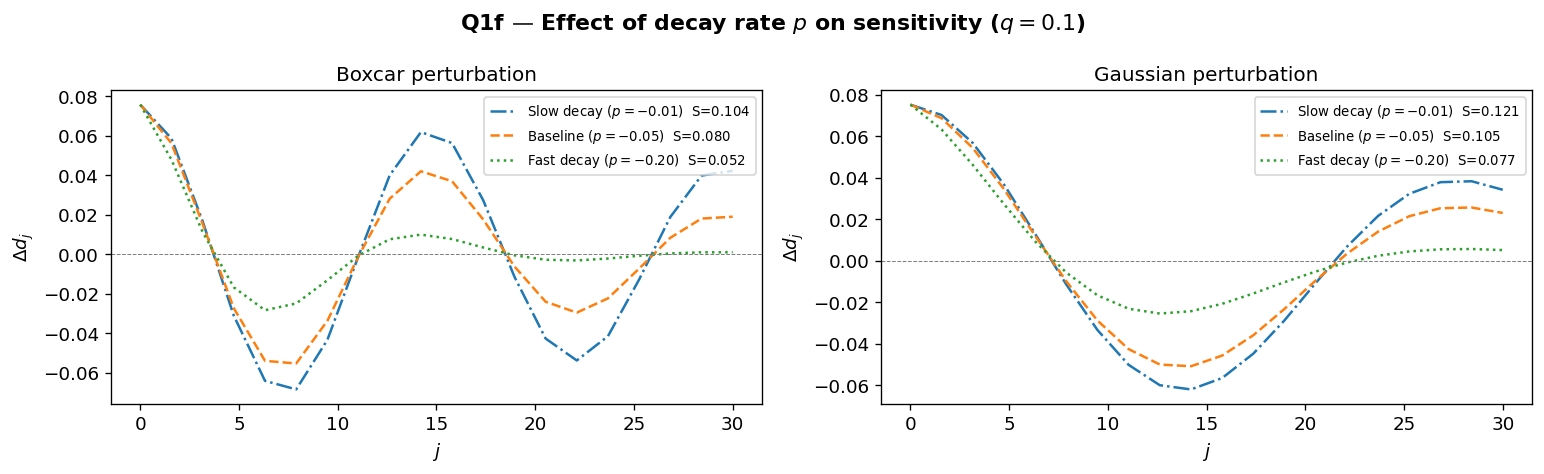

In [7]:
p_vals_exp = [-0.01, -0.05, -0.20]
labels_p   = ['Slow decay ($p=-0.01$)', 'Baseline ($p=-0.05$)', 'Fast decay ($p=-0.20$)']
line_styles_p = ['-.', '--', ':']

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

print(f'{'p':>6} | {'S_boxcar':>10} | {'S_gaussian':>12}')
print('-' * 34)

for p_v, ls, lbl in zip(p_vals_exp, line_styles_p, labels_p):
    G_v     = build_G(j_vals, p_v, q_main, x)
    d_v     = G_v @ m_true
    d_box_v = G_v @ m_boxcar_perturbed
    d_gau_v = G_v @ m_gauss_perturbed

    S_b = np.linalg.norm(d_v - d_box_v) / np.linalg.norm(m_true - m_boxcar_perturbed)
    S_g = np.linalg.norm(d_v - d_gau_v) / np.linalg.norm(m_true - m_gauss_perturbed)
    print(f'{p_v:>6.2f} | {S_b:>10.4f} | {S_g:>12.4f}')

    axes[0].plot(j_vals, d_box_v - d_v, ls, label=f'{lbl}  S={S_b:.3f}')
    axes[1].plot(j_vals, d_gau_v - d_v, ls, label=f'{lbl}  S={S_g:.3f}')

for ax, title in zip(axes, ['Boxcar perturbation', 'Gaussian perturbation']):
    ax.axhline(0, color='gray', linewidth=0.6, linestyle='--')
    ax.set_xlabel('$j$'); ax.set_ylabel('$\\Delta d_j$')
    ax.set_title(title); ax.legend(fontsize=8)

fig.suptitle('Q1f — Effect of decay rate $p$ on sensitivity ($q=0.1$)', fontweight='bold')
plt.tight_layout()
plt.savefig('figures/q1f_p_sensitivity.pdf', bbox_inches='tight')
plt.show()

---
# Q2 — The Inverse Problem

We minimise:
$$\phi(\mathbf{m}) = \|\mathbf{W}_d(\mathbf{G}\mathbf{m} - \mathbf{d}^\text{obs})\|^2 + \beta\left[\alpha_s\|\mathbf{W}_s\mathbf{m}\|^2 + \alpha_x\|\mathbf{W}_x\mathbf{m}\|^2\right]$$

## Q2a — Regularisation matrices Wd, Ws, Wx

- **$\mathbf{W}_d$**: $N\times N$ diagonal, entries $1/\varepsilon_i$
- **$\mathbf{W}_s$**: $M\times M$ scaled identity, $\sqrt{\Delta x}\,\mathbf{I}$
- **$\mathbf{W}_x$**: $(M-1)\times M$ first-difference matrix, scaled by $1/\sqrt{\Delta x}$

In [8]:
def make_Wd(std_devs):
    """N×N diagonal data weighting matrix: W_d = diag(1/sigma_i)."""
    return np.diag(1.0 / np.asarray(std_devs))


def make_Ws(x):
    """M×M smallness matrix: sqrt(dx) * I."""
    dx = x[1] - x[0]
    return np.sqrt(dx) * np.eye(len(x))


def make_Wx(x):
    """(M-1)×M first-derivative smoothness matrix, scaled by 1/sqrt(dx)."""
    n  = len(x)
    dx = x[1] - x[0]
    # First difference: D[i, i] = -1, D[i, i+1] = +1
    D = (np.eye(n, k=1) - np.eye(n))[:n-1, :]
    return D / np.sqrt(dx)


# ── Test on small mesh (4 cells, 2 data) ──────────────────────────────────────
x_test   = np.linspace(0, 1, 4)
std_test = [0.1, 0.2]

Wd_test = make_Wd(std_test)
Ws_test = make_Ws(x_test)
Wx_test = make_Wx(x_test)

print('=== Small test case: 4 cells, 2 data ===')
print(f'\nWd  shape: {Wd_test.shape}')
print(np.round(Wd_test, 3))

print(f'\nWs  shape: {Ws_test.shape}')
print(np.round(Ws_test, 4))

print(f'\nWx  shape: {Wx_test.shape}')
print(np.round(Wx_test, 4))

=== Small test case: 4 cells, 2 data ===

Wd  shape: (2, 2)
[[10.  0.]
 [ 0.  5.]]

Ws  shape: (4, 4)
[[0.5774 0.     0.     0.    ]
 [0.     0.5774 0.     0.    ]
 [0.     0.     0.5774 0.    ]
 [0.     0.     0.     0.5774]]

Wx  shape: (3, 4)
[[-1.7321  1.7321  0.      0.    ]
 [ 0.     -1.7321  1.7321  0.    ]
 [ 0.      0.     -1.7321  1.7321]]


## Q2b — Derivation of normal equations

Setting $m_\text{ref}=\mathbf{0}$, taking $\nabla_\mathbf{m}\phi = 0$ gives:

$$\boxed{\left(\mathbf{G}^\top\mathbf{A}_d\mathbf{G} + \beta\mathbf{R}\right)\tilde{\mathbf{m}} = \mathbf{G}^\top\mathbf{A}_d\,\mathbf{d}^\text{obs}}$$

where $\mathbf{A}_d = \mathbf{W}_d^\top\mathbf{W}_d$ and $\mathbf{R} = \alpha_s\mathbf{W}_s^\top\mathbf{W}_s + \alpha_x\mathbf{W}_x^\top\mathbf{W}_x$.

*(See write-up for full derivation.)*

## Q2c — Inversion function and results

In [9]:
def invert(G, d_obs, std_devs, beta, alpha_s, alpha_x, x):
    """
    Solve the Tikhonov-regularised inverse problem.

    Parameters
    ----------
    G       : (N, M) forward matrix
    d_obs   : (N,)   observed data
    std_devs: (N,)   data standard deviations
    beta    : float  regularisation parameter
    alpha_s : float  smallness weight
    alpha_x : float  smoothness weight
    x       : (M,)   mesh cell centres

    Returns
    -------
    m_rec  : (M,) recovered model
    phi_d  : data misfit
    phi_m  : model norm
    """
    Wd = make_Wd(std_devs)
    Ws = make_Ws(x)
    Wx = make_Wx(x)

    Ad  = Wd.T @ Wd
    R   = alpha_s * (Ws.T @ Ws) + alpha_x * (Wx.T @ Wx)
    LHS = G.T @ Ad @ G + beta * R
    RHS = G.T @ Ad @ d_obs

    m_rec = np.linalg.solve(LHS, RHS)

    residual = Wd @ (G @ m_rec - d_obs)
    phi_d    = residual @ residual

    if alpha_s > 0:
        phi_m = alpha_s * np.linalg.norm(Ws @ m_rec) ** 2
    else:
        phi_m = 0.0
    if alpha_x > 0:
        phi_m += alpha_x * np.linalg.norm(Wx @ m_rec) ** 2

    return m_rec, phi_d, phi_m


def plot_inversion_result(m_true, m_rec, G, d_obs, d_pred, j_vals, x,
                          title='Inversion result', ax_row=None):
    """Three-panel plot: model | kernels | data."""
    if ax_row is None:
        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    else:
        axes = ax_row

    axes[0].plot(x, m_true, 'k',  linewidth=1.8, label='True')
    axes[0].plot(x, m_rec,  'r--', linewidth=1.5, label='Recovered')
    axes[0].set_xlabel('x'); axes[0].set_ylabel('m(x)')
    axes[0].set_title('Model'); axes[0].legend()

    ck = cm.plasma(np.linspace(0.05, 0.95, G.shape[0]))
    for g_row, c in zip(G, ck):
        axes[1].plot(x, g_row / dx, color=c, alpha=0.6)
    axes[1].set_xlabel('x'); axes[1].set_title('Kernels')

    axes[2].plot(j_vals, d_obs,  'k.', markersize=7, label='Observed (noisy)')
    axes[2].plot(j_vals, d_pred, 'r-o', markersize=4, label='Predicted')
    axes[2].set_xlabel('$j$'); axes[2].set_ylabel('$d_j$')
    axes[2].set_title('Data'); axes[2].legend()

    if ax_row is None:
        plt.suptitle(title, fontweight='bold')
        plt.tight_layout()
        return plt.gcf()
    else:
        axes[0].set_title(title)


# ── Add noise ────────────────────────────────────────────────────────────────
np.random.seed(42)
noise_std = 1e-2
std_devs  = np.full(n_data, noise_std)
d_obs     = d_true + noise_std * np.random.randn(n_data)

N = n_data   # target misfit

# ── Scenario 1: smallness (alpha_s=1, alpha_x=0) ─────────────────────────────
print('Scenario 1: Smallness regularisation')
for beta in [1e4, 1e3, 1e2, 10, 1]:
    _, phi_d, _ = invert(G, d_obs, std_devs, beta, alpha_s=1, alpha_x=0, x=x)
    print(f'  beta={beta:.0e}  phi_d={phi_d:.2f}  (target N={N})')

print()
# ── Scenario 2: smoothness (alpha_s=0, alpha_x=1) ────────────────────────────
print('Scenario 2: Smoothness regularisation')
for beta in [1e5, 1e4, 1e3, 100, 10]:
    _, phi_d, _ = invert(G, d_obs, std_devs, beta, alpha_s=0, alpha_x=1, x=x)
    print(f'  beta={beta:.0e}  phi_d={phi_d:.2f}  (target N={N})')

Scenario 1: Smallness regularisation
  beta=1e+04  phi_d=307.94  (target N=20)
  beta=1e+03  phi_d=19.74  (target N=20)
  beta=1e+02  phi_d=7.90  (target N=20)
  beta=1e+01  phi_d=7.56  (target N=20)
  beta=1e+00  phi_d=7.53  (target N=20)

Scenario 2: Smoothness regularisation
  beta=1e+05  phi_d=1033.54  (target N=20)
  beta=1e+04  phi_d=976.97  (target N=20)
  beta=1e+03  phi_d=698.11  (target N=20)
  beta=1e+02  phi_d=223.80  (target N=20)
  beta=1e+01  phi_d=21.89  (target N=20)


Scenario 1: beta=1e+03, phi_d=19.74 (target 20)
Scenario 2: beta=1e+01, phi_d=21.89 (target 20)


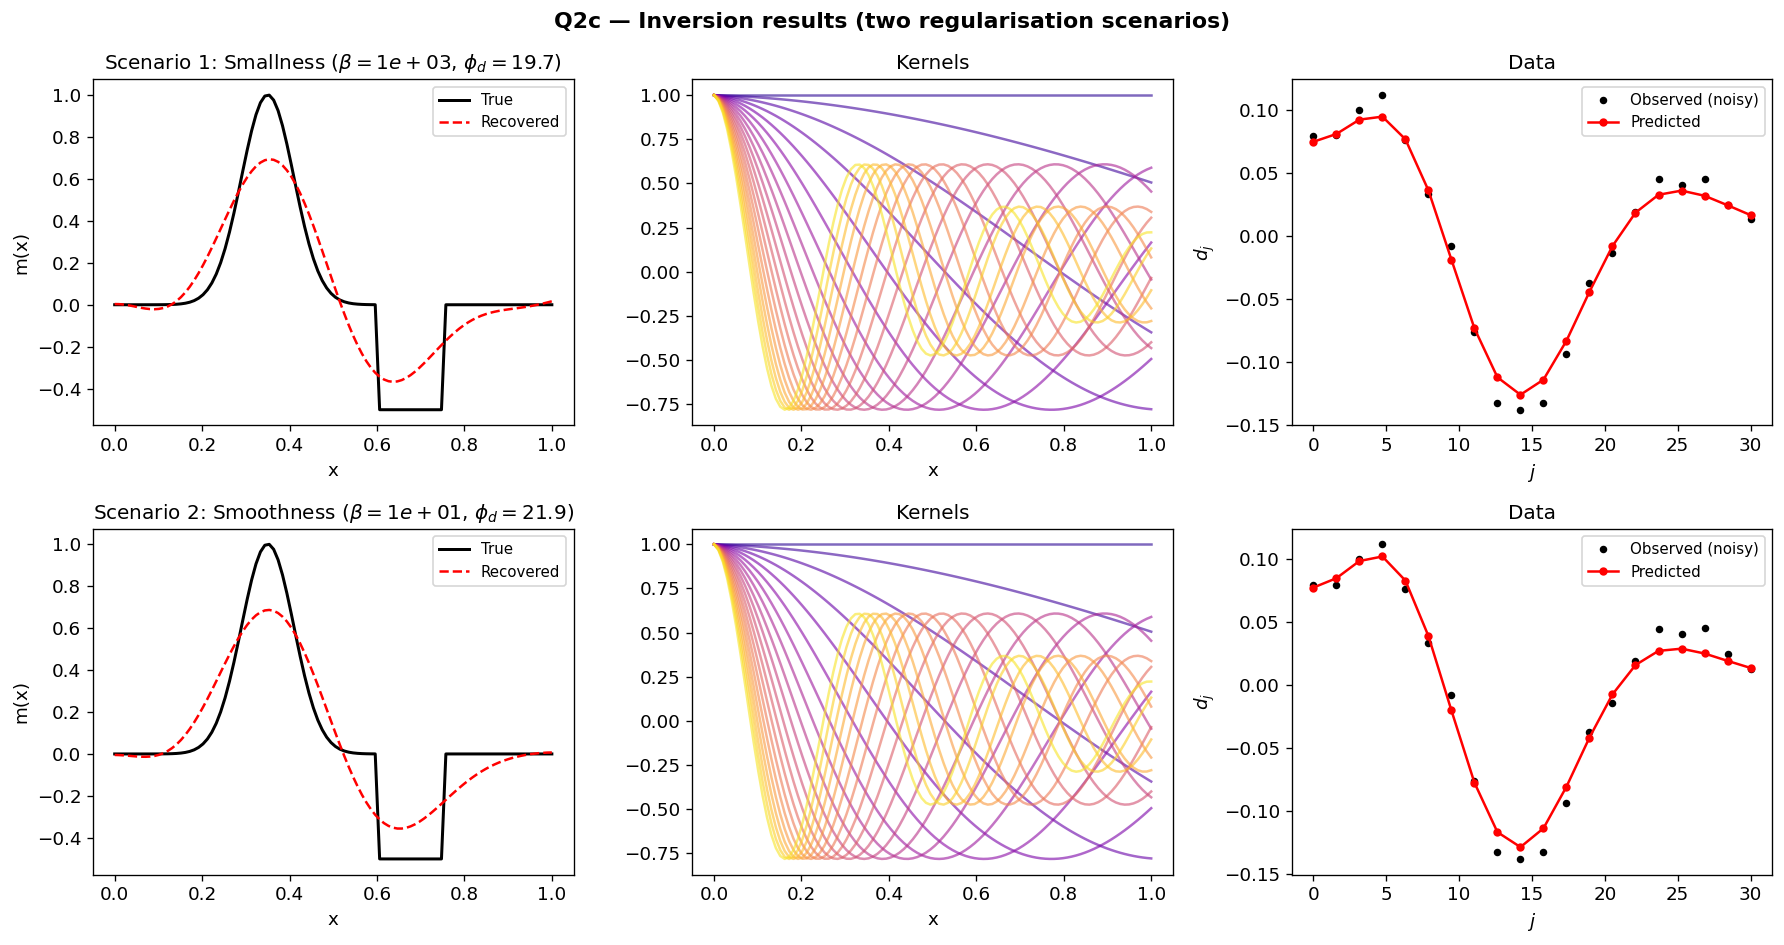

In [10]:
# ── Choose beta values that give phi_d ~ N ────────────────────────────────────
# (Adjust based on the sweep above)
beta_s1 = 1e3    # Scenario 1 — smallness  (phi_d ~ N=20)
beta_s2 = 10     # Scenario 2 — smoothness (phi_d ~ N=20)

m_s1, phi_d_s1, phi_m_s1 = invert(G, d_obs, std_devs, beta_s1, 1, 0, x)
m_s2, phi_d_s2, phi_m_s2 = invert(G, d_obs, std_devs, beta_s2, 0, 1, x)

print(f'Scenario 1: beta={beta_s1:.0e}, phi_d={phi_d_s1:.2f} (target {N})')
print(f'Scenario 2: beta={beta_s2:.0e}, phi_d={phi_d_s2:.2f} (target {N})')

# ── Combined figure ───────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

plot_inversion_result(
    m_true, m_s1, G, d_obs, G @ m_s1, j_vals, x,
    title=f'Scenario 1: Smallness ($\\beta={beta_s1:.0e}$, $\\phi_d={phi_d_s1:.1f}$)',
    ax_row=axes[0]
)
plot_inversion_result(
    m_true, m_s2, G, d_obs, G @ m_s2, j_vals, x,
    title=f'Scenario 2: Smoothness ($\\beta={beta_s2:.0e}$, $\\phi_d={phi_d_s2:.1f}$)',
    ax_row=axes[1]
)

fig.suptitle('Q2c — Inversion results (two regularisation scenarios)', fontweight='bold')
plt.tight_layout()
plt.savefig('figures/q2c_inversion.pdf', bbox_inches='tight')
plt.show()

---
# Q3 — Tikhonov Curves

In [11]:
def compute_tikhonov_curve(G, d_obs, std_devs, betas, alpha_s, alpha_x, x):
    """Compute phi_d and phi_m for a list of beta values."""
    phi_d_list, phi_m_list, models = [], [], []
    for beta in betas:
        m_rec, phi_d, phi_m = invert(G, d_obs, std_devs, beta, alpha_s, alpha_x, x)
        phi_d_list.append(phi_d)
        phi_m_list.append(phi_m)
        models.append(m_rec)
    return np.array(phi_d_list), np.array(phi_m_list), models


def plot_tikhonov_panels(betas, phi_d_vals, phi_m_vals, models, G, d_obs, j_vals, x,
                         m_true, N_target, highlight_idxs, scenario_label,
                         highlight_labels=('Underfit', 'Acceptable', 'Overfit'),
                         highlight_colors=('C1', 'C2', 'C3')):
    """Six-panel Tikhonov curve figure."""
    # Find largest beta where phi_d <= N_target
    star_idx = next((i for i, v in enumerate(phi_d_vals) if v <= N_target), 0)

    fig, axes = plt.subplots(2, 3, figsize=(15, 9))

    # ── Row 1: Tikhonov curves ────────────────────────────────────────────────
    ax = axes[0, 0]
    ax.semilogx(betas, phi_d_vals, 'b-')
    ax.axhline(N_target, color='k', linestyle='--', linewidth=1, label=f'Target $\\phi_d={N_target}$')
    ax.plot(betas[star_idx], phi_d_vals[star_idx], 'k*', markersize=14, label='Optimal $\\beta$')
    for idx, lbl, col in zip(highlight_idxs, highlight_labels, highlight_colors):
        ax.plot(betas[idx], phi_d_vals[idx], 'o', color=col, markersize=9, label=lbl)
    ax.set_xlabel('$\\beta$ (decreasing →)'); ax.set_ylabel('$\\phi_d$')
    ax.set_title('$\\phi_d$ vs $\\beta$'); ax.invert_xaxis(); ax.legend(fontsize=7)

    ax = axes[0, 1]
    ax.semilogx(betas, phi_m_vals, 'r-')
    ax.plot(betas[star_idx], phi_m_vals[star_idx], 'k*', markersize=14)
    for idx, col in zip(highlight_idxs, highlight_colors):
        ax.plot(betas[idx], phi_m_vals[idx], 'o', color=col, markersize=9)
    ax.set_xlabel('$\\beta$ (decreasing →)'); ax.set_ylabel('$\\phi_m$')
    ax.set_title('$\\phi_m$ vs $\\beta$'); ax.invert_xaxis()

    ax = axes[0, 2]
    ax.plot(phi_m_vals, phi_d_vals, 'g-')
    ax.axhline(N_target, color='k', linestyle='--', linewidth=1)
    ax.plot(phi_m_vals[star_idx], phi_d_vals[star_idx], 'k*', markersize=14)
    for idx, col in zip(highlight_idxs, highlight_colors):
        ax.plot(phi_m_vals[idx], phi_d_vals[idx], 'o', color=col, markersize=9)
    ax.set_xlabel('$\\phi_m$'); ax.set_ylabel('$\\phi_d$')
    ax.set_title('Tikhonov curve ($\\phi_d$ vs $\\phi_m$)')

    # ── Row 2: best model, kernels, data ─────────────────────────────────────
    m_best   = models[star_idx]
    d_pred   = G @ m_best

    axes[1, 0].plot(x, m_true, 'k', linewidth=1.8, label='True')
    axes[1, 0].plot(x, m_best, 'r--', linewidth=1.5, label=f'Recovered ($\\beta={betas[star_idx]:.1e}$)')
    for idx, lbl, col in zip(highlight_idxs, highlight_labels, highlight_colors):
        axes[1, 0].plot(x, models[idx], ':', color=col, linewidth=1.2, label=lbl)
    axes[1, 0].set_xlabel('x'); axes[1, 0].set_ylabel('m(x)')
    axes[1, 0].set_title('True & recovered models'); axes[1, 0].legend(fontsize=7)

    ck = cm.plasma(np.linspace(0.05, 0.95, G.shape[0]))
    for g_row, c in zip(G, ck):
        axes[1, 1].plot(x, g_row / dx, color=c, alpha=0.5)
    axes[1, 1].set_xlabel('x'); axes[1, 1].set_title('Kernels')

    axes[1, 2].plot(j_vals, d_obs,   'k.', markersize=8, label='Noisy observed')
    axes[1, 2].plot(j_vals, d_pred,  'r-o', markersize=4, label='Predicted (optimal $\\beta$)')
    axes[1, 2].set_xlabel('$j$'); axes[1, 2].set_ylabel('$d_j$')
    axes[1, 2].set_title('Data'); axes[1, 2].legend(fontsize=8)

    fig.suptitle(f'Q3 — Tikhonov curves: {scenario_label}', fontweight='bold')
    plt.tight_layout()
    return fig


betas = np.logspace(6, -6, 50)
N_target = n_data

## Q3a — Smallness regularisation (α_s=1, α_x=0)

Underfit  (idx=7):  beta=1.9e+04,  phi_d=516.4
Acceptable (idx=13): beta=6.6e+02,  phi_d=13.5  ← optimal star
Overfit   (idx=23):  beta=2.3e+00,  phi_d=7.5


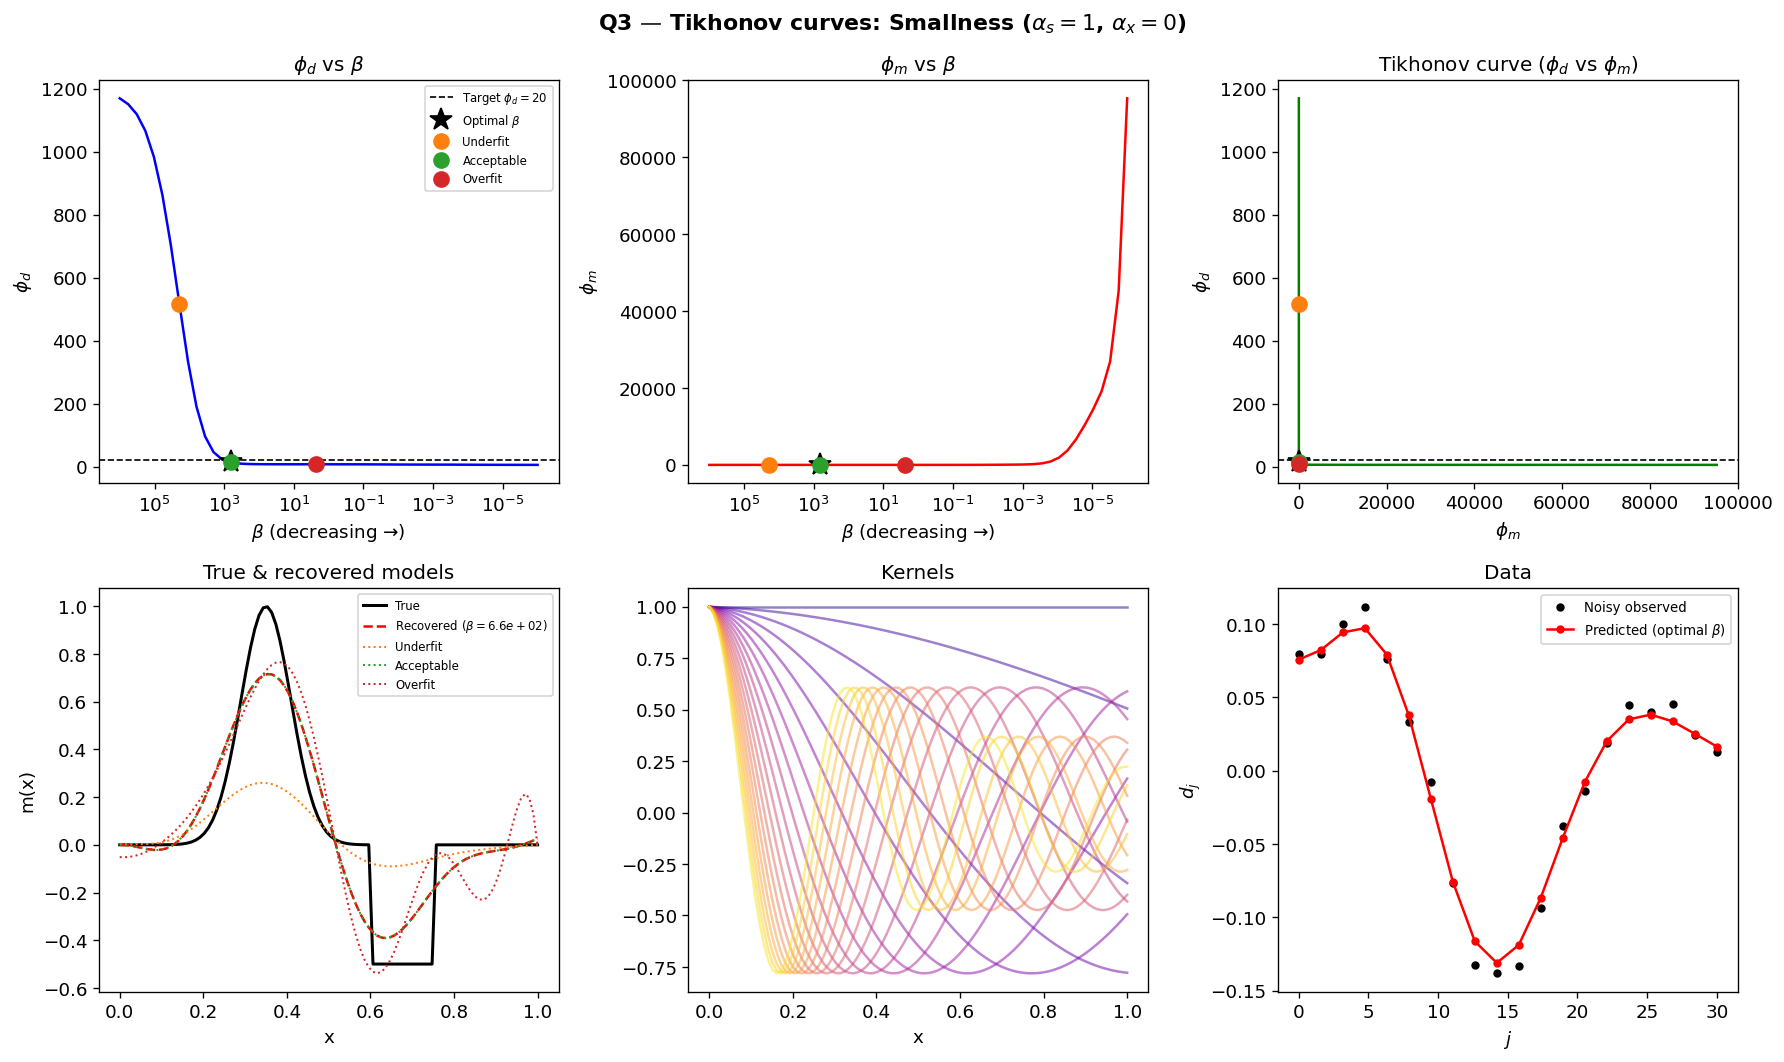

In [12]:
phi_d_s, phi_m_s, models_s = compute_tikhonov_curve(
    G, d_obs, std_devs, betas, alpha_s=1, alpha_x=0, x=x
)

# Choose 3 representative beta indices (not extremes)
# Underfit: large beta (large phi_d), Acceptable: near target, Overfit: small phi_d
star_idx_s = next((i for i, v in enumerate(phi_d_s) if v <= N_target), 0)
uf_idx  = max(star_idx_s - 6, 1)          # clearly underfit but not at extreme
acc_idx = star_idx_s                       # first beta that reaches target
of_idx  = min(star_idx_s + 10, len(betas)-2)  # clearly overfit but not at extreme

print(f'Underfit  (idx={uf_idx}):  beta={betas[uf_idx]:.1e},  phi_d={phi_d_s[uf_idx]:.1f}')
print(f'Acceptable (idx={acc_idx}): beta={betas[acc_idx]:.1e},  phi_d={phi_d_s[acc_idx]:.1f}  ← optimal star')
print(f'Overfit   (idx={of_idx}):  beta={betas[of_idx]:.1e},  phi_d={phi_d_s[of_idx]:.1f}')

fig = plot_tikhonov_panels(
    betas, phi_d_s, phi_m_s, models_s, G, d_obs, j_vals, x,
    m_true, N_target,
    highlight_idxs=[uf_idx, acc_idx, of_idx],
    scenario_label='Smallness ($\\alpha_s=1$, $\\alpha_x=0$)'
)
fig.savefig('figures/q3a_tikhonov_smallness.pdf', bbox_inches='tight')
plt.show()

## Q3b — Smoothness regularisation (α_s=0, α_x=1)

Underfit  (idx=15):  beta=2.1e+02,  phi_d=371.8
Acceptable (idx=21): beta=7.2e+00,  phi_d=16.3
Overfit   (idx=31):  beta=2.6e-02,  phi_d=7.6


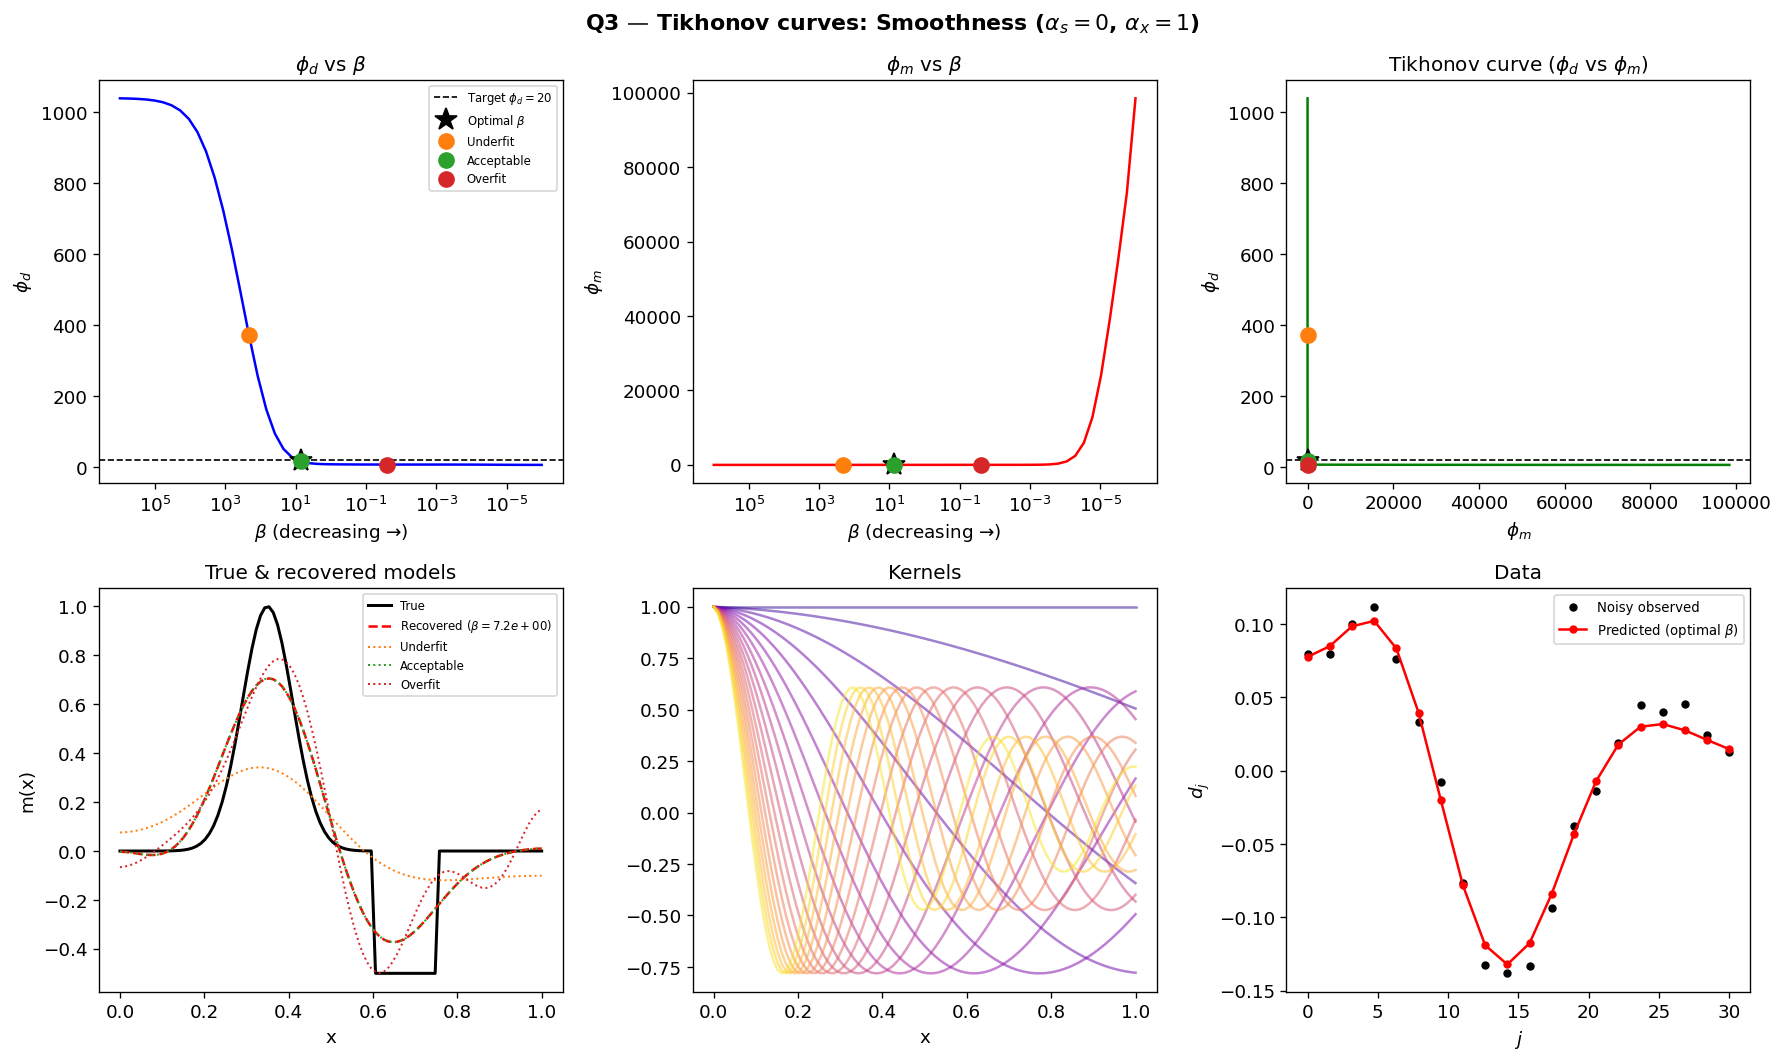

In [13]:
phi_d_x, phi_m_x, models_x = compute_tikhonov_curve(
    G, d_obs, std_devs, betas, alpha_s=0, alpha_x=1, x=x
)

uf_idx_x  = max(next((i for i, v in enumerate(phi_d_x) if v <= N_target), 0) - 6, 1)
acc_idx_x = next((i for i, v in enumerate(phi_d_x) if v <= N_target), 0)
of_idx_x  = min(acc_idx_x + 10, len(betas)-2)

print(f'Underfit  (idx={uf_idx_x}):  beta={betas[uf_idx_x]:.1e},  phi_d={phi_d_x[uf_idx_x]:.1f}')
print(f'Acceptable (idx={acc_idx_x}): beta={betas[acc_idx_x]:.1e},  phi_d={phi_d_x[acc_idx_x]:.1f}')
print(f'Overfit   (idx={of_idx_x}):  beta={betas[of_idx_x]:.1e},  phi_d={phi_d_x[of_idx_x]:.1f}')

fig = plot_tikhonov_panels(
    betas, phi_d_x, phi_m_x, models_x, G, d_obs, j_vals, x,
    m_true, N_target,
    highlight_idxs=[uf_idx_x, acc_idx_x, of_idx_x],
    scenario_label='Smoothness ($\\alpha_s=0$, $\\alpha_x=1$)'
)
fig.savefig('figures/q3b_tikhonov_smoothness.pdf', bbox_inches='tight')
plt.show()

## Q3c — Exploration: Effect of noise level on Tikhonov curves

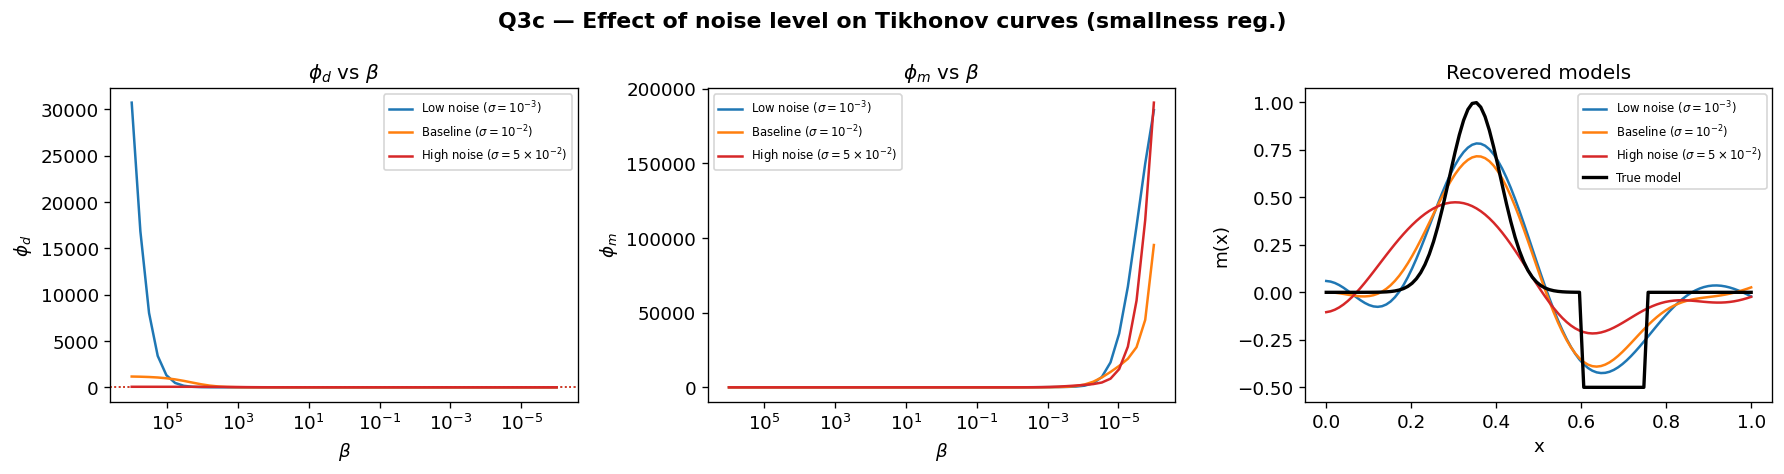

In [14]:
noise_levels = [1e-3, 1e-2, 5e-2]
labels_noise = ['Low noise ($\\sigma=10^{-3}$)',
                'Baseline ($\\sigma=10^{-2}$)',
                'High noise ($\\sigma=5\\times10^{-2}$)']
colors_noise = ['C0', 'C1', 'C3']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for sigma, lbl, col in zip(noise_levels, labels_noise, colors_noise):
    np.random.seed(42)
    d_noisy = d_true + sigma * np.random.randn(n_data)
    stds    = np.full(n_data, sigma)
    N_t     = n_data

    phi_d_n, phi_m_n, mdls_n = compute_tikhonov_curve(
        G, d_noisy, stds, betas, alpha_s=1, alpha_x=0, x=x
    )

    axes[0].semilogx(betas, phi_d_n, color=col, label=lbl)
    axes[0].axhline(N_t, color=col, linestyle=':', linewidth=1)

    axes[1].semilogx(betas, phi_m_n, color=col, label=lbl)

    # Best model for this noise level
    best_idx = next((i for i, v in enumerate(phi_d_n) if v <= N_t), 0)
    axes[2].plot(x, mdls_n[best_idx], color=col, label=lbl)

axes[2].plot(x, m_true, 'k', linewidth=2, label='True model')

for ax, title in zip(axes, ['$\\phi_d$ vs $\\beta$', '$\\phi_m$ vs $\\beta$', 'Recovered models']):
    ax.set_title(title); ax.legend(fontsize=7)
axes[0].set_xlabel('$\\beta$'); axes[0].set_ylabel('$\\phi_d$'); axes[0].invert_xaxis()
axes[1].set_xlabel('$\\beta$'); axes[1].set_ylabel('$\\phi_m$'); axes[1].invert_xaxis()
axes[2].set_xlabel('x'); axes[2].set_ylabel('m(x)')

fig.suptitle('Q3c — Effect of noise level on Tikhonov curves (smallness reg.)', fontweight='bold')
plt.tight_layout()
plt.savefig('figures/q3c_noise_exploration.pdf', bbox_inches='tight')
plt.show()

---
# Q4 — Singular Value Decomposition (SVD)

## Q4a — SVD of the forward matrix G

G shape:  (20, 100)
U shape:  (20, 20)  (N × K, left singular vectors — data space)
s shape:  (20,)  (K singular values)
V shape:  (100, 20)  (M × K, right singular vectors — model space)

First 5 singular values: [0.14244058 0.12112246 0.10552611 0.09240347 0.07728123]
Condition number: 1.53e+15


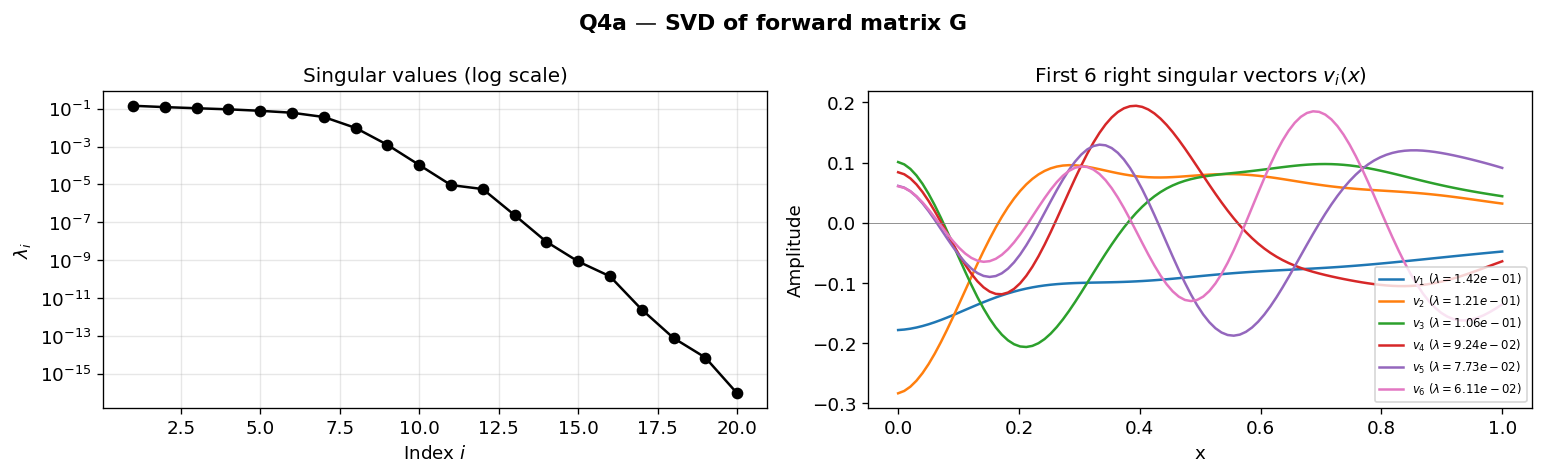

In [15]:
# Reuse the main G from Q1c (p=-0.05, q=0.1, N=20)
U, s, Vt = np.linalg.svd(G, full_matrices=False)
V = Vt.T

print(f'G shape:  {G.shape}')
print(f'U shape:  {U.shape}  (N × K, left singular vectors — data space)')
print(f's shape:  {s.shape}  (K singular values)')
print(f'V shape:  {V.shape}  (M × K, right singular vectors — model space)')
print(f'\nFirst 5 singular values: {s[:5]}')
print(f'Condition number: {s[0]/s[-1]:.2e}')

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Panel 1: singular values
axes[0].semilogy(np.arange(1, len(s)+1), s, 'ko-', markersize=6)
axes[0].set_xlabel('Index $i$'); axes[0].set_ylabel('$\\lambda_i$')
axes[0].set_title('Singular values (log scale)')
axes[0].grid(True, which='both', alpha=0.3)

# Panel 2: first 6 right singular vectors
n_svec = 6
colors_sv = cm.tab10(np.linspace(0, 0.6, n_svec))
for i, c in zip(range(n_svec), colors_sv):
    axes[1].plot(x, V[:, i], color=c, label=f'$v_{{{i+1}}}$ ($\\lambda={s[i]:.2e}$)')
axes[1].set_xlabel('x'); axes[1].set_ylabel('Amplitude')
axes[1].set_title('First 6 right singular vectors $v_i(x)$')
axes[1].legend(fontsize=7); axes[1].axhline(0, color='gray', linewidth=0.5)

fig.suptitle('Q4a — SVD of forward matrix $\\mathbf{G}$', fontweight='bold')
plt.tight_layout()
plt.savefig('figures/q4a_svd.pdf', bbox_inches='tight')
plt.show()

## Q4b — Truncated SVD solution

$$\tilde{\mathbf{m}}_c = \sum_{i=1}^{p} \frac{\mathbf{u}_i^\top \mathbf{d}^\text{obs}}{\lambda_i}\,\mathbf{v}_i$$

Acceptable p = 6  (phi_d = 9.51, target N = 20)


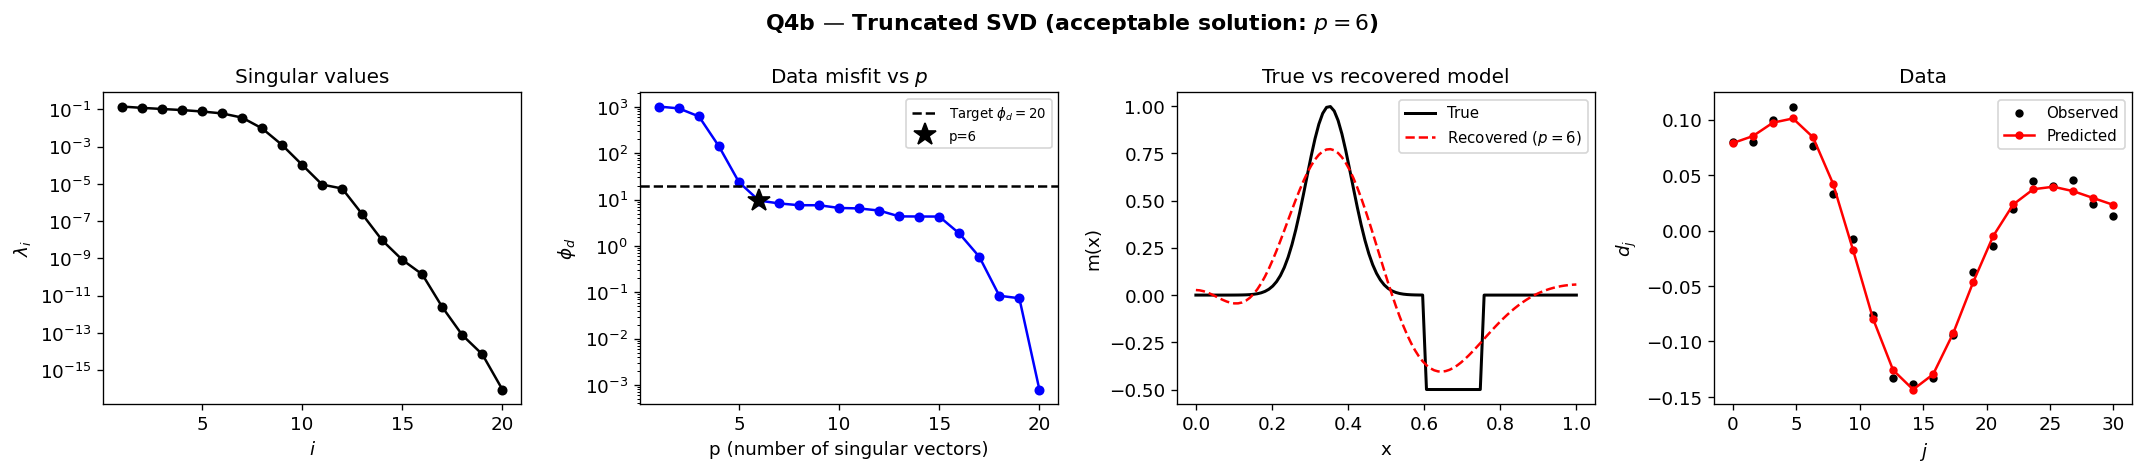

In [16]:
def tsvd(G, d_obs, p_trunc):
    """
    Truncated SVD solution using p_trunc singular vectors.

    Parameters
    ----------
    G       : (N, M) forward matrix
    d_obs   : (N,)   observed data
    p_trunc : int    number of singular vectors to include

    Returns
    -------
    m_rec  : (M,) recovered model
    """
    U_t, s_t, Vt_t = np.linalg.svd(G, full_matrices=False)
    V_t = Vt_t.T
    m_rec = np.zeros(G.shape[1])
    for i in range(p_trunc):
        coeff  = (U_t[:, i] @ d_obs) / s_t[i]
        m_rec += coeff * V_t[:, i]
    return m_rec


# Sweep over p
p_max    = len(s)
p_range  = np.arange(1, p_max + 1)
phi_d_svd = []
Wd_main   = make_Wd(std_devs)

for p_t in p_range:
    m_rec = tsvd(G, d_obs, p_t)
    res   = Wd_main @ (G @ m_rec - d_obs)
    phi_d_svd.append(res @ res)

# Find the acceptable p (phi_d first crosses N_target from above)
acc_p_idx = next((i for i, v in enumerate(phi_d_svd) if v <= N_target), len(p_range)-1)
acc_p     = p_range[acc_p_idx]
print(f'Acceptable p = {acc_p}  (phi_d = {phi_d_svd[acc_p_idx]:.2f}, target N = {N_target})')

m_acc = tsvd(G, d_obs, acc_p)

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

axes[0].semilogy(p_range, s, 'ko-', markersize=5)
axes[0].set_xlabel('$i$'); axes[0].set_ylabel('$\\lambda_i$')
axes[0].set_title('Singular values')

axes[1].semilogy(p_range, phi_d_svd, 'b-o', markersize=5)
axes[1].axhline(N_target, color='k', linestyle='--', label=f'Target $\\phi_d={N_target}$')
axes[1].plot(acc_p, phi_d_svd[acc_p_idx], 'k*', markersize=14, label=f'p={acc_p}')
axes[1].set_xlabel('p (number of singular vectors)')
axes[1].set_ylabel('$\\phi_d$'); axes[1].set_title('Data misfit vs $p$')
axes[1].legend(fontsize=8)

axes[2].plot(x, m_true, 'k', linewidth=1.8, label='True')
axes[2].plot(x, m_acc,  'r--', linewidth=1.5, label=f'Recovered ($p={acc_p}$)')
axes[2].set_xlabel('x'); axes[2].set_ylabel('m(x)')
axes[2].set_title('True vs recovered model'); axes[2].legend()

axes[3].plot(j_vals, d_obs,        'k.', markersize=8, label='Observed')
axes[3].plot(j_vals, G @ m_acc,    'r-o', markersize=4, label='Predicted')
axes[3].set_xlabel('$j$'); axes[3].set_ylabel('$d_j$')
axes[3].set_title('Data'); axes[3].legend()

fig.suptitle(f'Q4b — Truncated SVD (acceptable solution: $p={acc_p}$)', fontweight='bold')
plt.tight_layout()
plt.savefig('figures/q4b_tsvd.pdf', bbox_inches='tight')
plt.show()

## Q4c — Underfit, acceptable and overfit TSVD solutions

Underfit   p=2:   phi_d = 926.56
Acceptable p=6: phi_d = 9.51  (target 20)
Overfit    p=18:   phi_d = 0.08


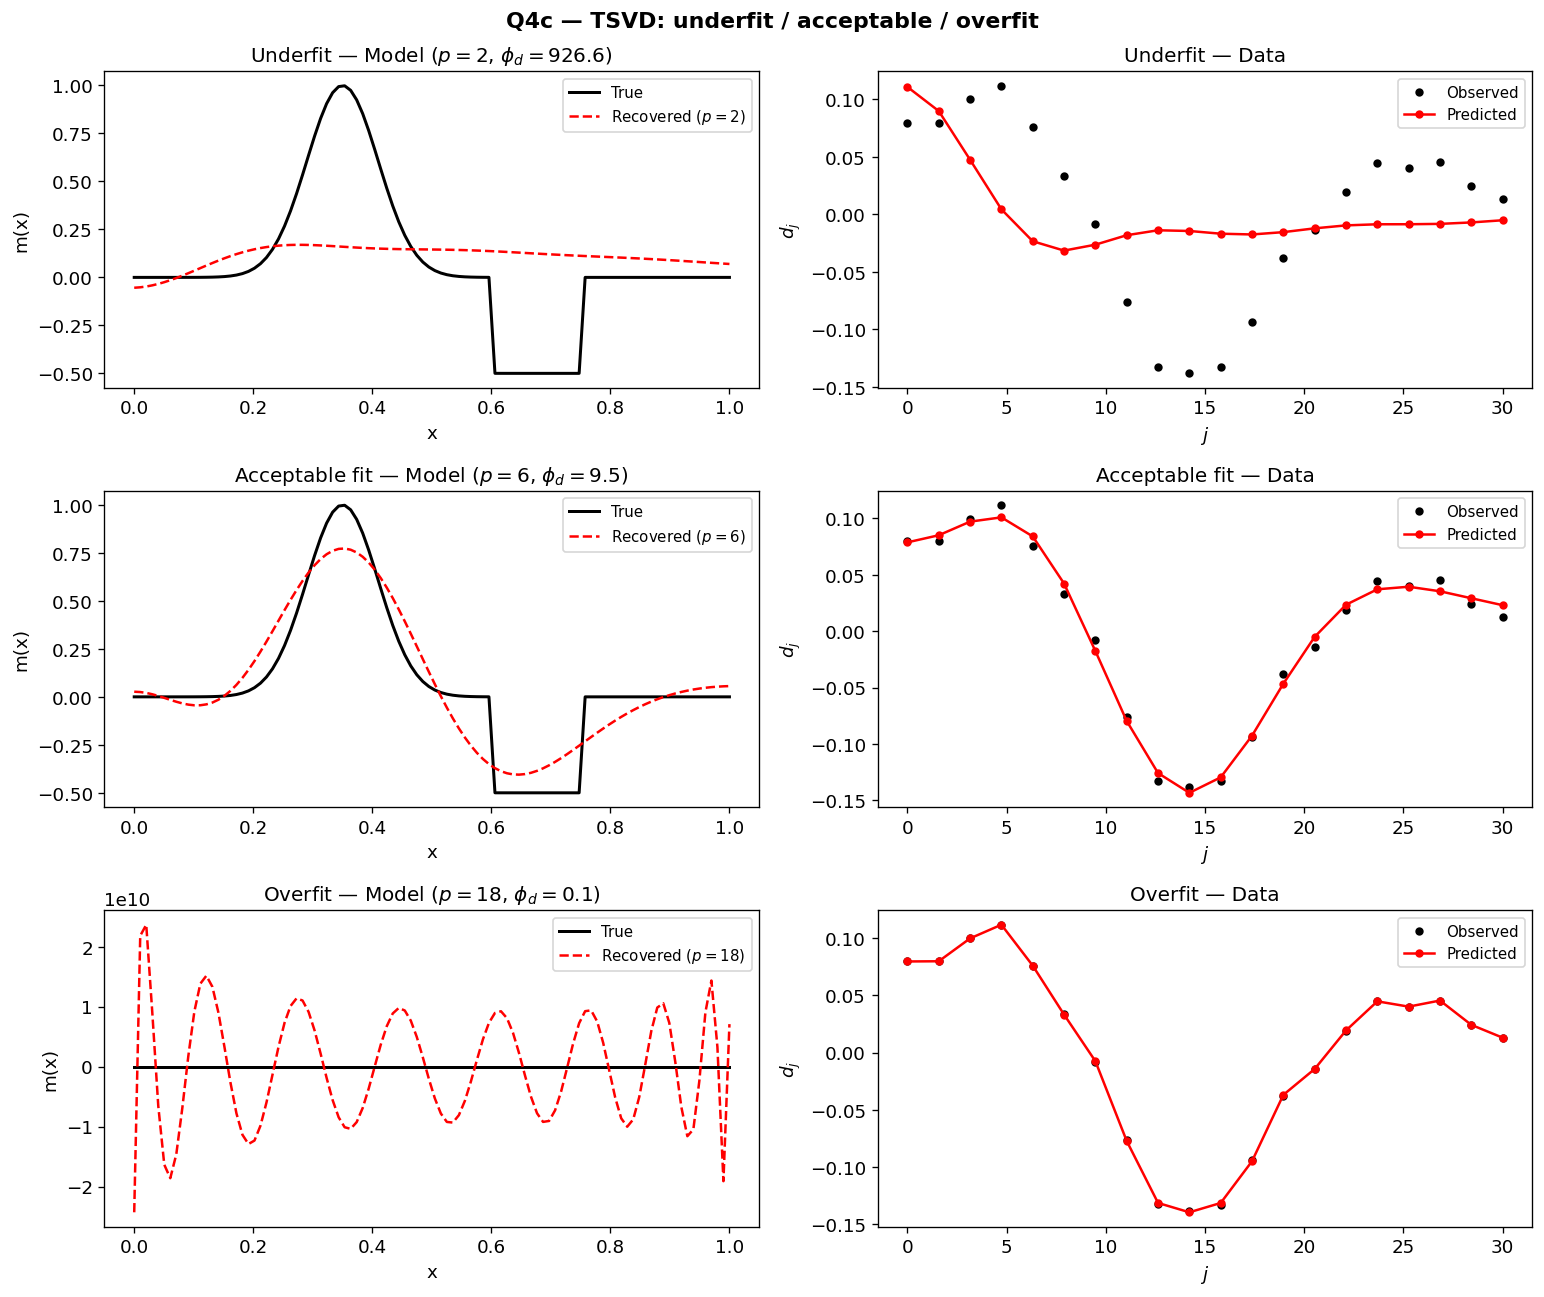

In [17]:
p_underfit   = 2
p_acceptable = acc_p      # from Q4b
p_overfit    = min(18, p_max)

m_uf  = tsvd(G, d_obs, p_underfit)
m_acc = tsvd(G, d_obs, p_acceptable)
m_of  = tsvd(G, d_obs, p_overfit)

def phi_d_tsvd(G, d_obs, std_devs, m_rec):
    Wd = make_Wd(std_devs)
    res = Wd @ (G @ m_rec - d_obs)
    return res @ res

pd_uf  = phi_d_tsvd(G, d_obs, std_devs, m_uf)
pd_acc = phi_d_tsvd(G, d_obs, std_devs, m_acc)
pd_of  = phi_d_tsvd(G, d_obs, std_devs, m_of)

print(f'Underfit   p={p_underfit}:   phi_d = {pd_uf:.2f}')
print(f'Acceptable p={p_acceptable}: phi_d = {pd_acc:.2f}  (target {N_target})')
print(f'Overfit    p={p_overfit}:   phi_d = {pd_of:.2f}')

fig, axes = plt.subplots(3, 2, figsize=(13, 11))

for row, (m_r, p_t, pd, lbl) in enumerate([
        (m_uf,  p_underfit,   pd_uf,  'Underfit'),
        (m_acc, p_acceptable, pd_acc, 'Acceptable fit'),
        (m_of,  p_overfit,    pd_of,  'Overfit'),
]):
    axes[row, 0].plot(x, m_true, 'k', linewidth=1.8, label='True')
    axes[row, 0].plot(x, m_r,   'r--', linewidth=1.5, label=f'Recovered ($p={p_t}$)')
    axes[row, 0].set_xlabel('x'); axes[row, 0].set_ylabel('m(x)')
    axes[row, 0].set_title(f'{lbl} — Model ($p={p_t}$, $\\phi_d={pd:.1f}$)')
    axes[row, 0].legend()

    axes[row, 1].plot(j_vals, d_obs,     'k.', markersize=8, label='Observed')
    axes[row, 1].plot(j_vals, G @ m_r,   'r-o', markersize=4, label='Predicted')
    axes[row, 1].set_xlabel('$j$'); axes[row, 1].set_ylabel('$d_j$')
    axes[row, 1].set_title(f'{lbl} — Data')
    axes[row, 1].legend()

fig.suptitle('Q4c — TSVD: underfit / acceptable / overfit', fontweight='bold')
plt.tight_layout()
plt.savefig('figures/q4c_tsvd_three.pdf', bbox_inches='tight')
plt.show()

## Q4d — Exploration: effect of kernel oscillation frequency on SVD

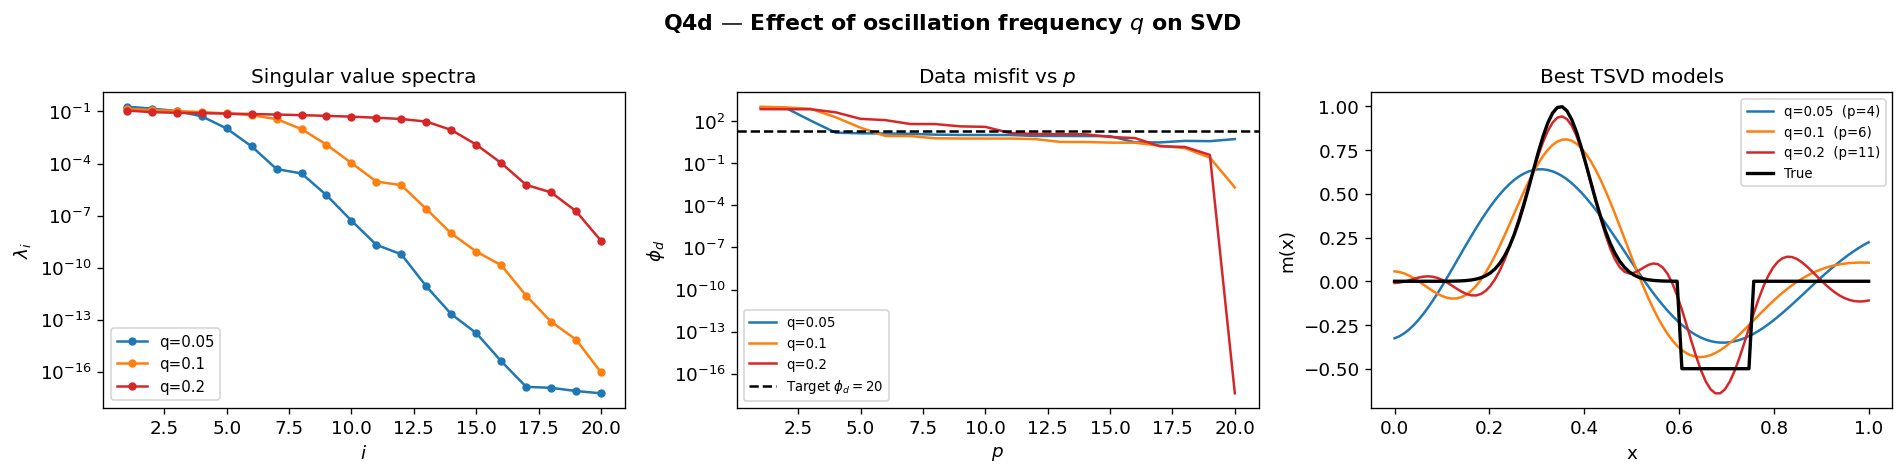


All figures saved to ./figures/


In [18]:
q_explore = [0.05, 0.10, 0.20]
colors_qe = ['C0', 'C1', 'C3']

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for q_v, col in zip(q_explore, colors_qe):
    G_v    = build_G(j_vals, p_main, q_v, x)
    d_v    = G_v @ m_true + noise_std * np.random.randn(n_data)
    stds_v = np.full(n_data, noise_std)
    Wd_v   = make_Wd(stds_v)

    _, s_v, _ = np.linalg.svd(G_v, full_matrices=False)

    # Compute phi_d vs p
    pd_v = []
    for p_t in p_range:
        m_r = tsvd(G_v, d_v, min(p_t, len(s_v)))
        res = Wd_v @ (G_v @ m_r - d_v)
        pd_v.append(res @ res)

    # Best model
    best_idx_v = next((i for i, v in enumerate(pd_v) if v <= N_target), 0)
    m_best_v   = tsvd(G_v, d_v, p_range[best_idx_v])

    axes[0].semilogy(p_range[:len(s_v)], s_v, '-o', color=col, markersize=4,
                     label=f'q={q_v}')
    axes[1].semilogy(p_range, pd_v, '-', color=col, label=f'q={q_v}')
    axes[2].plot(x, m_best_v, color=col,
                 label=f'q={q_v}  (p={p_range[best_idx_v]})')

axes[2].plot(x, m_true, 'k', linewidth=2, label='True')

axes[0].set_xlabel('$i$'); axes[0].set_ylabel('$\\lambda_i$')
axes[0].set_title('Singular value spectra'); axes[0].legend()

axes[1].axhline(N_target, color='k', linestyle='--', label=f'Target $\\phi_d={N_target}$')
axes[1].set_xlabel('$p$'); axes[1].set_ylabel('$\\phi_d$')
axes[1].set_title('Data misfit vs $p$'); axes[1].legend(fontsize=8)

axes[2].set_xlabel('x'); axes[2].set_ylabel('m(x)')
axes[2].set_title('Best TSVD models'); axes[2].legend(fontsize=8)

fig.suptitle('Q4d — Effect of oscillation frequency $q$ on SVD', fontweight='bold')
plt.tight_layout()
plt.savefig('figures/q4d_svd_q_exploration.pdf', bbox_inches='tight')
plt.show()

print('\nAll figures saved to ./figures/')